In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import itertools
import random
import os
import csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # # Force TensorFlow to use single thread
    # # Multiple threads are a potential source of non-reproducible results.
    # session_conf = tf.compat.v1.ConfigProto(
    #     intra_op_parallelism_threads=1,
    #     inter_op_parallelism_threads=1
    # )

    # # Make sure that TensorFlow uses a deterministic operation wherever possible
    # tf.compat.v1.set_random_seed(seed)

    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [4]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/kaggle/input/nyse/prices.csv", 
                 parse_dates=["date"], 
                 index_col=["date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [6]:
df.symbol.unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 

In [7]:
len(df)

851264

In [8]:
# Access the 'symbol' column and convert it to a list
symbol_list = df['symbol'].tolist()

# Pick a random symbol from the list
random_symbol = random.choice(symbol_list)

print("Random symbol:", random_symbol)

Random symbol: PCG


In [9]:
# Recreate DataFrame with rows where symbol = "KSU"
df_price = df[df['symbol'] == random_symbol]

# Print information about the new DataFrame
df_price.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1762 non-null   object 
 1   open    1762 non-null   float64
 2   close   1762 non-null   float64
 3   low     1762 non-null   float64
 4   high    1762 non-null   float64
 5   volume  1762 non-null   float64
dtypes: float64(5), object(1)
memory usage: 96.4+ KB


In [10]:
len(df_price)

1762

In [11]:
# Only want closing price for each day 
df_prices = pd.DataFrame(df_price["close"]).rename(columns={"close": "Price"})
df_prices.head()

,Price
date,
2010-01-04,44.500000
2010-01-05,44.000000
2010-01-06,44.509998
2010-01-07,43.750000
2010-01-08,43.790001


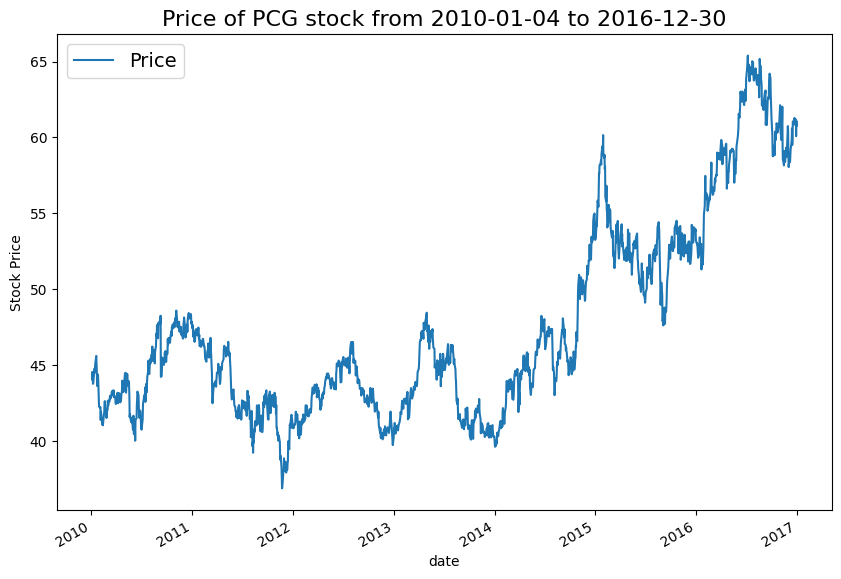

In [12]:
import matplotlib.pyplot as plt
df_prices.plot(figsize=(10, 7))
plt.ylabel("Stock Price")
plt.title(f"Price of {random_symbol} stock from 2010-01-04 to 2016-12-30", fontsize=16)
plt.legend(fontsize=14);

In [13]:
import csv

# Open the CSV file
with open("/kaggle/input/nyse/prices.csv", "r") as f:
    # Create a CSV reader object
    reader = csv.reader(f)
    
    # Read the first row (header) of the CSV file
    header = next(reader)
    
    # Print the column names
    print(header)


['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']


In [14]:
import csv
from datetime import datetime

timesteps = []
stock_price = []
with open("/kaggle/input/nyse/prices.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        if line[1] == random_symbol: # check if the symbol is KSU
            timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
            stock_price.append(float(line[3])) # get the closing price as float

# View first 10 of each
timesteps[:10], stock_price[:10]


([datetime.datetime(2010, 1, 4, 0, 0),
  datetime.datetime(2010, 1, 5, 0, 0),
  datetime.datetime(2010, 1, 6, 0, 0),
  datetime.datetime(2010, 1, 7, 0, 0),
  datetime.datetime(2010, 1, 8, 0, 0),
  datetime.datetime(2010, 1, 11, 0, 0),
  datetime.datetime(2010, 1, 12, 0, 0),
  datetime.datetime(2010, 1, 13, 0, 0),
  datetime.datetime(2010, 1, 14, 0, 0),
  datetime.datetime(2010, 1, 15, 0, 0)],
 [44.5,
  44.0,
  44.509998,
  43.75,
  43.790001,
  44.450001,
  44.5,
  44.77,
  44.490002,
  45.009998])

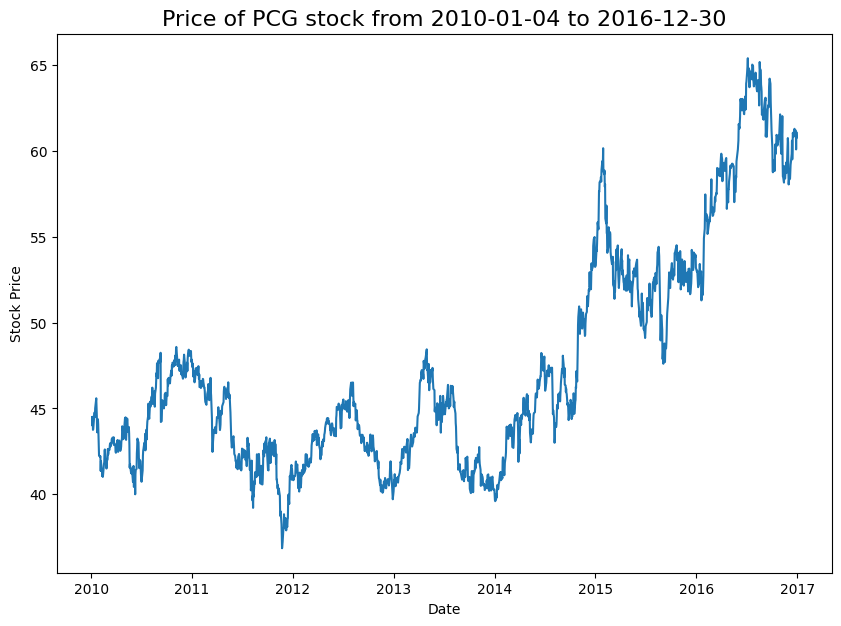

In [17]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, stock_price)
plt.title(f"Price of {random_symbol} stock from 2010-01-04 to 2016-12-30", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price");

In [18]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(stock_price)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], stock_price[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], stock_price[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1409, 353, 1409, 353)

In [19]:
# Convert list to NumPy array
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Now you can use .shape
print(X_train_np.shape, y_train_np.shape, X_test_np.shape, y_test_np.shape)

(1409,) (1409,) (353,) (353,)


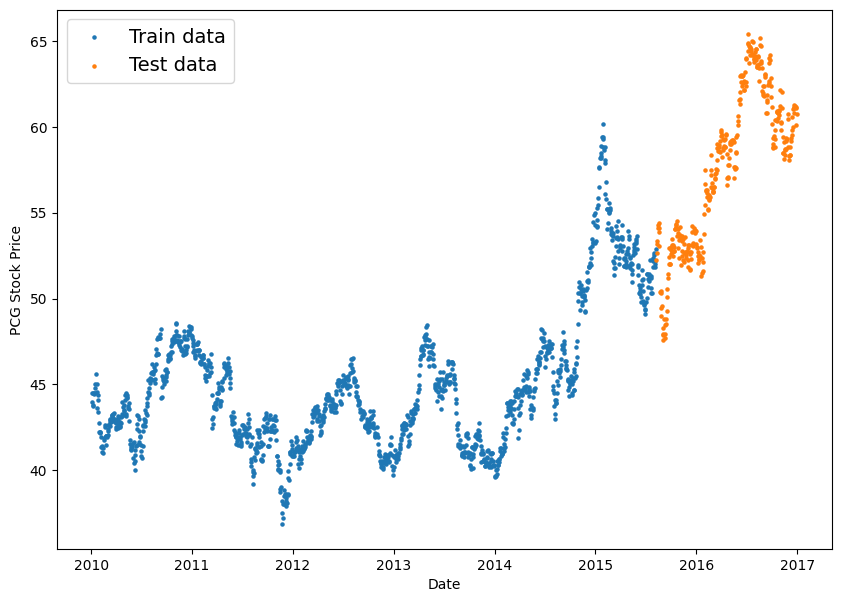

In [20]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel(f"{random_symbol} Stock Price")
plt.legend(fontsize=14)
plt.show();

In [21]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel(f"{random_symbol} Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

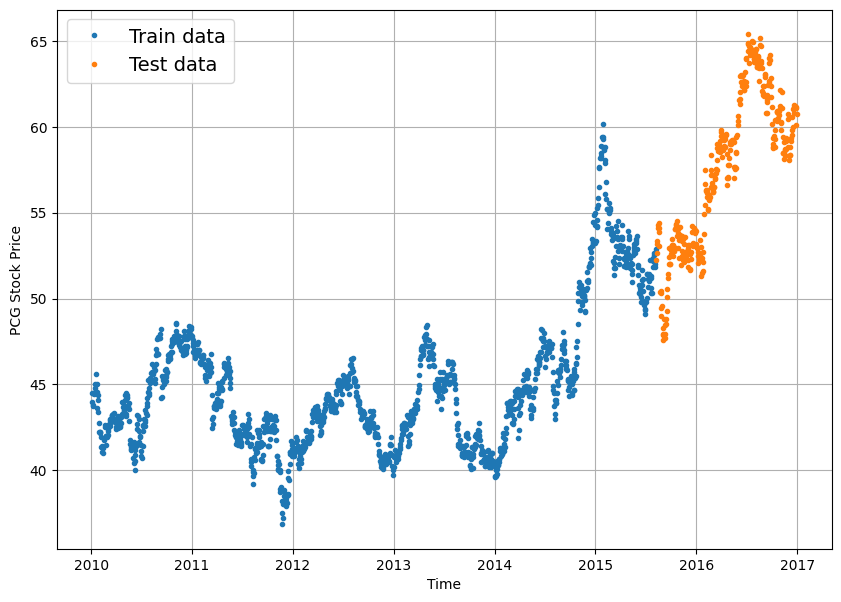

In [22]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [23]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shuffle=True):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      shuffle(bool) - whether to shuffle the dataset

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [26]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

In [27]:
# Generate the windowed dataset for the validation set, without shuffling
val_set = windowed_dataset(y_test, window_size, batch_size, shuffle_buffer_size, shuffle=False)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.
beatrix-ju

In [29]:
BATCH_SIZE=32

In [30]:
def build_model(hp):
    
    # Define all hyperparameters
    n_layers = hp.Choice('n_layers', [1, 2, 3])
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    n_units = hp.Choice('n_units', [50, 100, 200])
    n_filters = hp.Choice('n_filters', [32, 64, 128])
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    
    # Model architecture
    model = Sequential()
    
    # Lambda layer to expand dimensions
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]))
    
    # Conv1D for feature extraction
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Add LSTM layers 
    for i in range(n_layers):
        if i == 0:
            # First layer specifies return sequences if more than one LSTM layer
            model.add(Bidirectional(LSTM(n_units, return_sequences=(n_layers != 1), activation='relu')))
        else:
            # Middle layers return sequences, last layer doesn't
            model.add(Bidirectional(LSTM(n_units, return_sequences=(i != n_layers - 1), activation='relu')))
        
        # Add Dropout after each LSTM layer
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics = ['mean_absolute_error']
    )
    
    # Return model
    return model


In [31]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=20, 
    seed=42, 
    project_name="Stock_Search"
)

# Start Searching
search = random_searcher.search(
    train_set,
    validation_data=val_set,
    epochs = 30,
    batch_size = BATCH_SIZE
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |n_layers
0.2               |0.2               |dropout_rate
100               |100               |n_units
32                |32                |n_filters
5                 |5                 |kernel_size
0.001             |0.001             |learning_rate

Epoch 1/30
44/44 [==============================] - 15s 57ms/step - loss: 1729.8378 - mean_absolute_error: 40.7342 - val_loss: 272707.8750 - val_mean_absolute_error: 519.3478
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 900.0248 - mean_absolute_error: 26.0053 - val_loss: 50290.8789 - val_mean_absolute_error: 221.9226
Epoch 3/30
44/44 [==============================] - 1s 22ms/step - loss: 535.1957 - mean_absolute_error: 19.5280 - val_loss: 3336.3025 - val_mean_absolute_error: 56.8071
Epoch 4/30
44/44 [==============================] - 1s 25ms/step - loss: 100.7033 - mean_absolute_error: 7.6

KeyboardInterrupt: 

In [ ]:
# Collect the best model LSTM Model Architecture obtained by Random Searcher
best_model = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_model.summary()

In [ ]:
# Compile Model
best_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(best_model.optimizer.learning_rate),
    metrics=['mean_absolute_error']
)

# Model Training
best_model_history = best_model.fit(
    train_set,
    validation_data=val_set,
    epochs = 100,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ModelCheckpoint("BestModel.h5", save_best_only=True)
    ]
)

In [ ]:
#  Load model 
best_model = tf.keras.models.load_model('BestModel.h5')
best_model.summary()

In [ ]:
# Evaluate the best USE model
best_test_loss, best_test_acc = best_model.evaluate(val_set)
print(f"Validation MSE after Tuning     : {best_test_loss} ")
print(f"Validation MAE after Tuning : {best_test_acc}  ")


In [ ]:
# Extract the history from the best USE model
accuracy = best_model_history.history['mean_absolute_error']
val_accuracy = best_model_history.history['val_mean_absolute_error']

loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
split_size

In [ ]:
# Reduce the original series
forecast_series = stock_price[split_size-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(best_model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(X_test, (y_test, results))

**Multivariate**

In [34]:
df_price.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,PCG,44.950001,44.500000,44.450001,45.119999,2041800.0
2010-01-05,PCG,44.610001,44.000000,43.900002,44.820000,2599300.0
2010-01-06,PCG,43.889999,44.509998,43.779999,44.830002,2541200.0
2010-01-07,PCG,44.529999,43.750000,43.689999,44.639999,2377700.0
2010-01-08,PCG,43.490002,43.790001,43.340000,43.880001,1521400.0


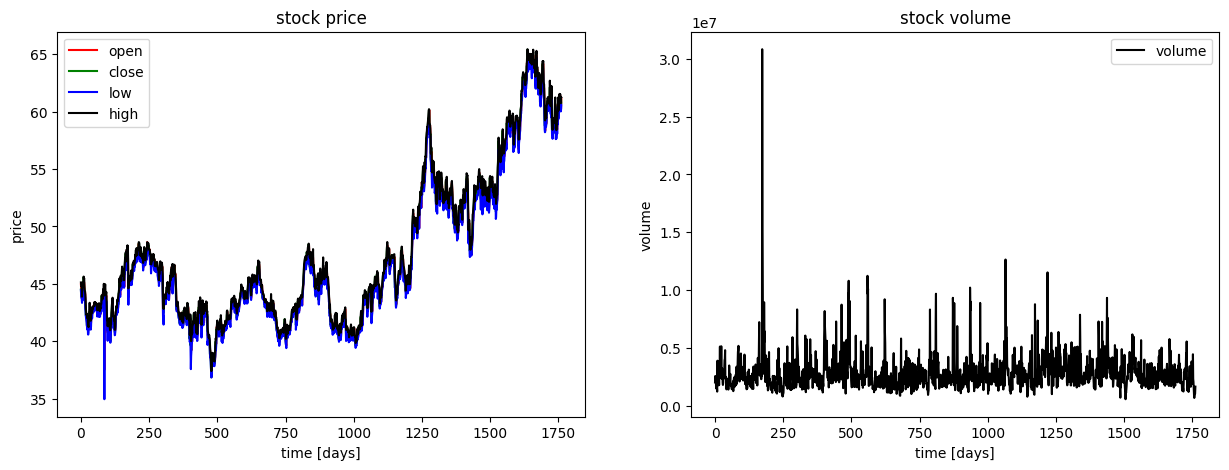

In [35]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df_price.open.values, color='red', label='open')
plt.plot(df_price.close.values, color='green', label='close')
plt.plot(df_price.low.values, color='blue', label='low')
plt.plot(df_price.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df_price.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [36]:
# Scalling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
data = df_price.copy()
data.drop(['symbol'], axis=1, inplace=True)
x = data[['open', 'low', 'high', 'volume']].copy()
y = data['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

#

In [37]:
x.shape, y.shape

((1762, 4), (1762, 1))

In [38]:
x, y

(                open       low      high    volume
 date                                              
 2010-01-04  0.285208  0.319865  0.275419  0.047971
 2010-01-05  0.273147  0.301347  0.264716  0.066420
 2010-01-06  0.247606  0.297306  0.265073  0.064497
 2010-01-07  0.270309  0.294276  0.258295  0.059086
 2010-01-08  0.233416  0.282492  0.231181  0.030749
 ...              ...       ...       ...       ...
 2016-12-23  0.868393  0.876094  0.860507  0.003683
 2016-12-27  0.849592  0.865657  0.854085  0.010494
 2016-12-28  0.844981  0.843771  0.832322  0.013445
 2016-12-29  0.827953  0.847475  0.849447  0.016142
 2016-12-30  0.858815  0.861953  0.850161  0.035942
 
 [1762 rows x 4 columns],
 array([[0.26778828],
        [0.25026286],
        [0.26813871],
        ...,
        [0.81388022],
        [0.84928148],
        [0.83806522]]))

In [39]:
#Splitting

def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

window = 7
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1579, 7, 5) (1579,) (175, 7, 5) (175,)


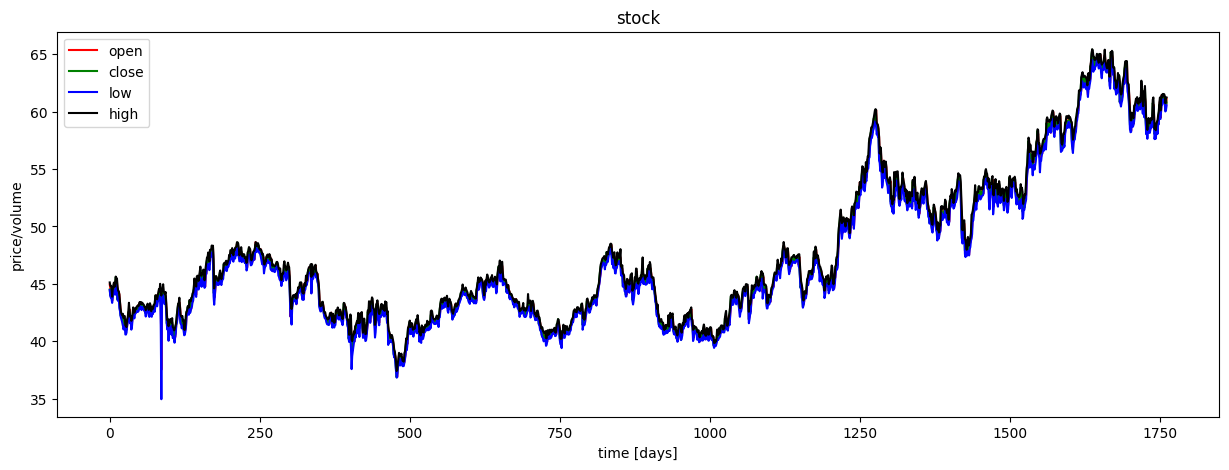

In [40]:
plt.figure(figsize=(15, 5));
plt.plot(df_price.open.values, color='red', label='open')
plt.plot(df_price.close.values, color='green', label='close')
plt.plot(df_price.low.values, color='blue', label='low')
plt.plot(df_price.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('price/volume')
plt.legend(loc='best')
plt.show()

**Model 1: LSTM**

In [41]:
import time

tf.random.set_seed(42) # set random seed for reproducibility

#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.5))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)


Epoch 1/100
43/43 [==============================] - 9s 41ms/step - loss: 0.0426 - val_loss: 0.0352
Epoch 2/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 3/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 4/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 5/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 6/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 7/100
43/43 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 8/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 9/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 10/100
43/43 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0034

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             11200     
                                                                 
 dropout_2 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_3 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)               

<AxesSubplot: >

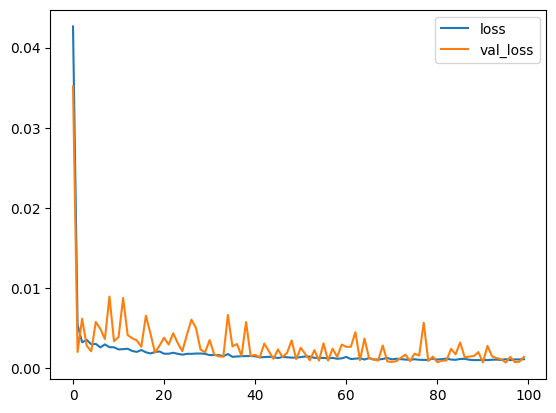

In [43]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

In [44]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

6/6 [==============================] - 0s 4ms/step


In [45]:
testPredict.shape

(175, 1)

In [46]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(175, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(175, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(175, 1)
(175, 1)


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [48]:
plot_x = df.index.copy()


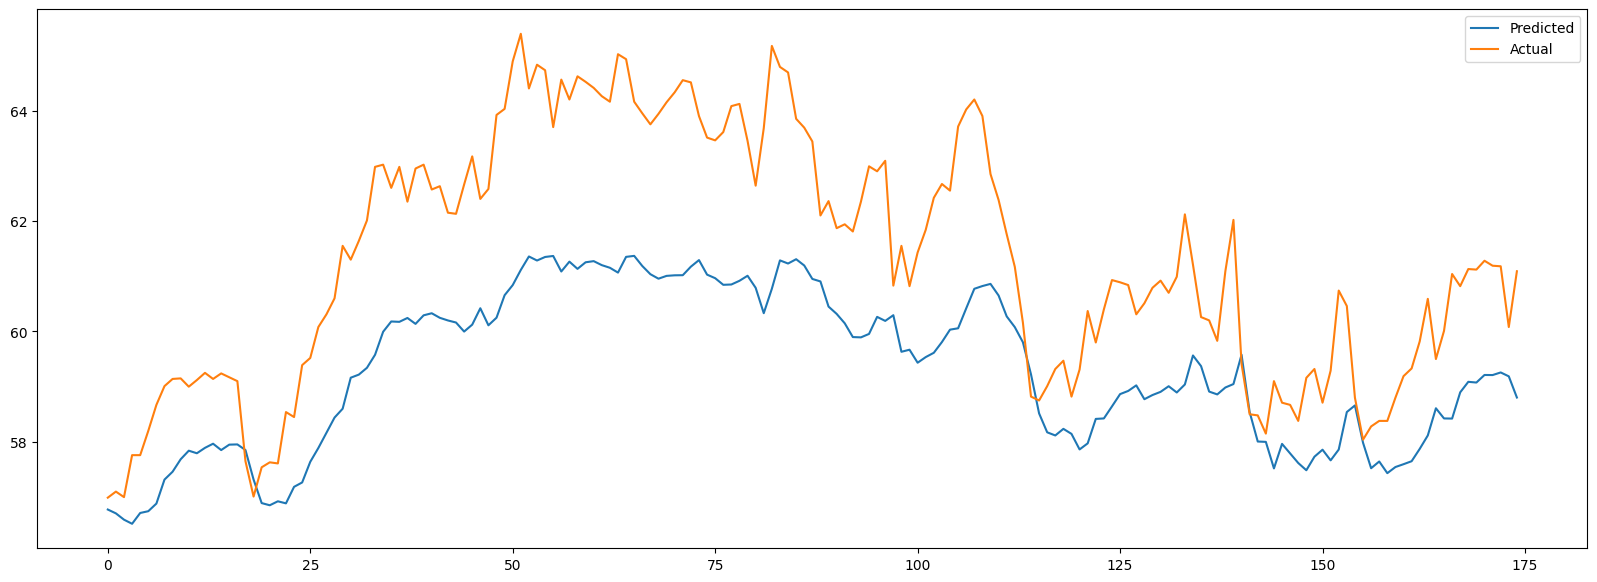

In [49]:
plt.figure(figsize=(20,7))
plot_x = plot_x[-174:]
plot_x = pd.to_datetime(plot_x)
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error, r2_score

trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.64 RMSE
Test Score: 2.25 RMSE


In [51]:
stock_prices = df_price.close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [52]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+22, :] = trainPredict

testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(stock_prices) - testPredict.shape[0]):len(stock_prices), :] = testPredict

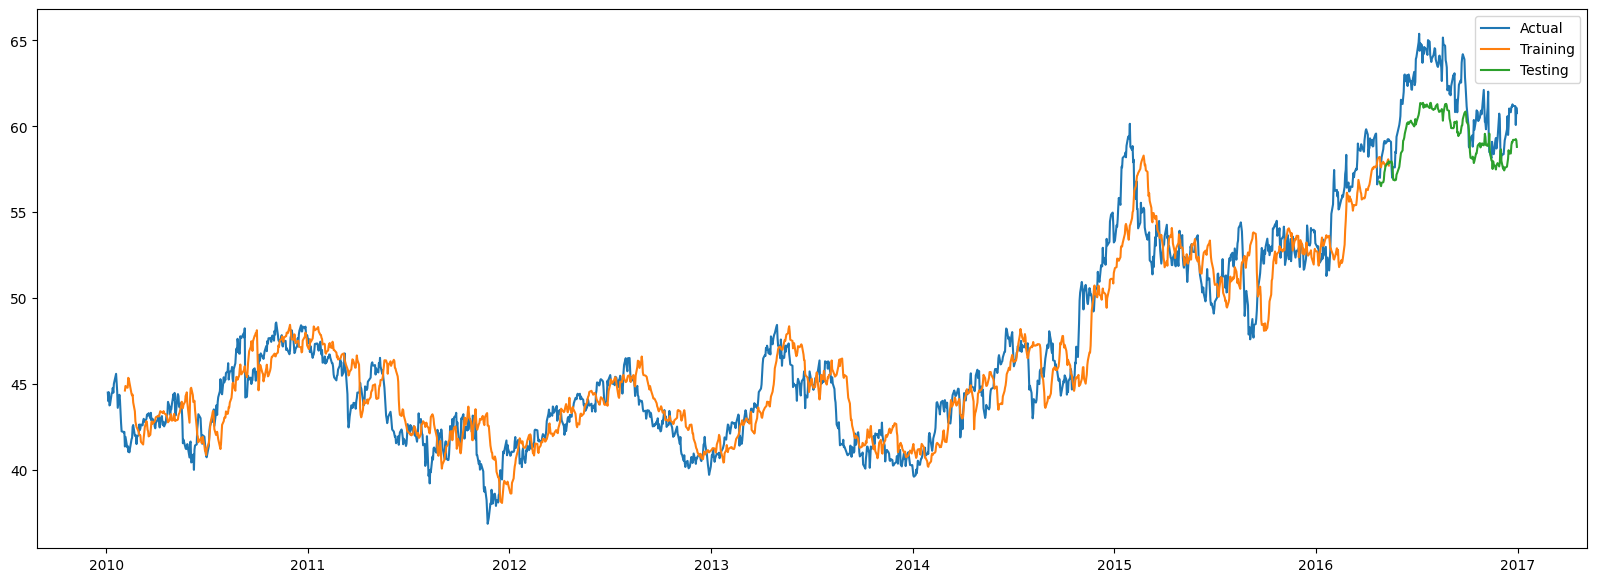

In [53]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=data.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=data.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

**Hyperparameter Tuning**

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


In [55]:
BATCH_SIZE=32

In [56]:
X_train.shape[1], X_train.shape[2]


(7, 5)

In [57]:
def build_model(hp):
    
    # Define all hyperparameters
    n_layers = hp.Choice('n_layers', [1, 2, 3])
    dropout_rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    n_units = hp.Choice('n_units', [50, 100, 200])
    n_filters = hp.Choice('n_filters', [32, 64, 128])
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    
    # Model architecture
    model = Sequential()
    
    # Conv1D for feature extraction
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Add LSTM layers 
    for i in range(n_layers):
        if i == 0:
            # First layer specifies return sequences if more than one LSTM layer
            model.add(Bidirectional(LSTM(n_units, return_sequences=(n_layers != 1), activation='relu')))
        else:
            # Middle layers return sequences, last layer doesn't
            model.add(Bidirectional(LSTM(n_units, return_sequences=(i != n_layers - 1), activation='relu')))
        
        # Add Dropout after each LSTM layer
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics = ['mean_absolute_error']
    )
    
    # Return model
    return model


In [58]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=15, 
    seed=42, 
    project_name="Stock-Search"
)

# Start Searching
search = random_searcher.search(
    X_train,y_train,
    validation_split=0.05,
    epochs = 30,
    batch_size = BATCH_SIZE
)

Trial 15 Complete [00h 00m 32s]
val_loss: 0.0014584459131583571

Best val_loss So Far: 0.0008053618366830051
Total elapsed time: 00h 13m 12s


In [59]:
# Collect the best model LSTM Model Architecture obtained by Random Searcher
best_model = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             704       
                                                                 
 batch_normalization_1 (Batc  (None, 6, 64)            256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 200)           132000    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 200)            0         
                                                      

In [60]:
# Compile Model
best_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(best_model.optimizer.learning_rate),
    metrics=['mean_absolute_error']
)

# Model Training
best_model_history = best_model.fit(
    X_train,y_train,
    validation_split=0.05,
    epochs = 100,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ModelCheckpoint("BestModel.h5", save_best_only=True)
    ]
)

Epoch 1/100
24/24 [==============================] - 8s 69ms/step - loss: 0.0444 - mean_absolute_error: 0.1697 - val_loss: 0.2783 - val_mean_absolute_error: 0.5213
Epoch 2/100
24/24 [==============================] - 1s 46ms/step - loss: 0.0047 - mean_absolute_error: 0.0506 - val_loss: 0.1969 - val_mean_absolute_error: 0.4362
Epoch 3/100
24/24 [==============================] - 1s 40ms/step - loss: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.1682 - val_mean_absolute_error: 0.4022
Epoch 4/100
24/24 [==============================] - 1s 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.1814 - val_mean_absolute_error: 0.4183
Epoch 5/100
24/24 [==============================] - 2s 72ms/step - loss: 0.0016 - mean_absolute_error: 0.0307 - val_loss: 0.1625 - val_mean_absolute_error: 0.3953
Epoch 6/100
24/24 [==============================] - 1s 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - val_loss: 0.1630 - val_mean_absolute_error: 0.3959
Epoch 7/100
24/2

In [61]:
#  Load model 
best_model = tf.keras.models.load_model('BestModel.h5')
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             704       
                                                                 
 batch_normalization_1 (Batc  (None, 6, 64)            256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 200)           132000    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 200)            0         
                                                      

In [64]:
best_model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0274


[0.0011718837777152658, 0.02740313485264778]

In [62]:
# Evaluate the best USE model
best_test_loss, best_test_acc = best_model.evaluate(X_test,y_test)
print(f"Validation MSE after Tuning     : {best_test_loss} ")
print(f"Validation MAE after Tuning : {best_test_acc}  ")


6/6 [==============================] - 1s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0274
Validation MSE after Tuning     : 0.0011718837777152658 
Validation MAE after Tuning : 0.02740313485264778  


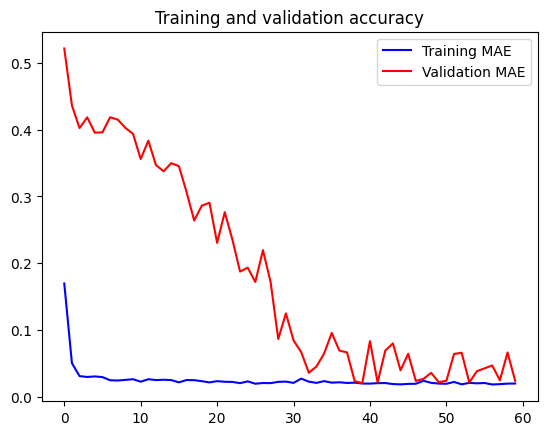

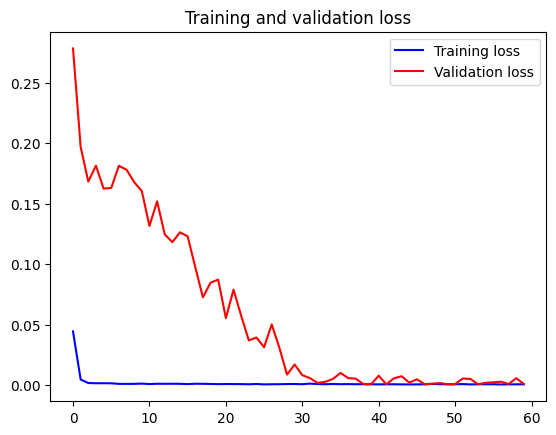

In [65]:
# Extract the history from the best USE model
accuracy = best_model_history.history['mean_absolute_error']
val_accuracy = best_model_history.history['val_mean_absolute_error']

loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [66]:
trainPredict = best_model.predict(X_train)
testPredict = best_model.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

6/6 [==============================] - 0s 4ms/step


In [68]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(175, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(175, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(175, 1)
(175, 1)


In [69]:
plot_x = df.index.copy()


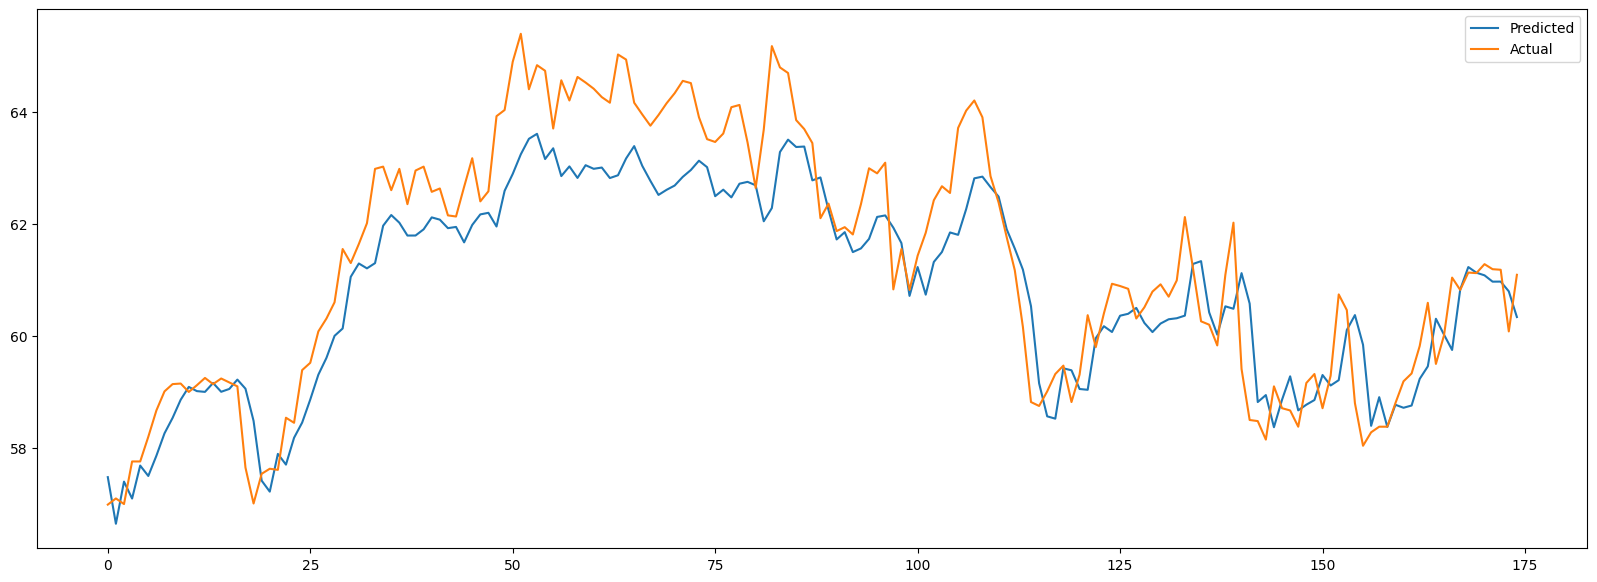

In [70]:
plt.figure(figsize=(20,7))
plot_x = plot_x[-174:]
plot_x = pd.to_datetime(plot_x)
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.65 RMSE
Test Score: 0.98 RMSE


In [72]:
stock_prices = df_price.close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [73]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+22, :] = trainPredict

testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(stock_prices) - testPredict.shape[0]):len(stock_prices), :] = testPredict

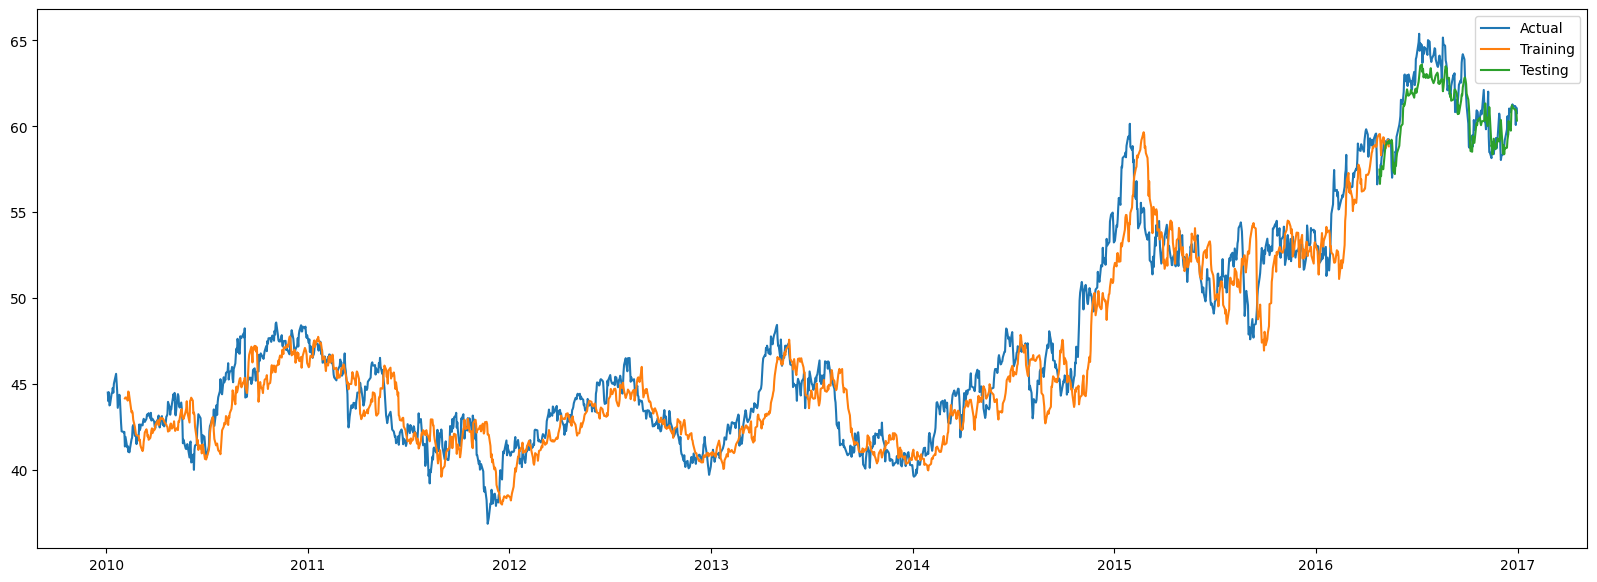

In [74]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=data.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=data.index).close, label='Testing')
plt.legend(loc='best')
plt.show()